In [1]:
using Plots
using Random
using Statistics
using Enzyme

In [2]:
@views function gravity(pos :: AbstractArray{Float64, 2}) :: AbstractArray{Float64, 2}
    vec_x = pos[1, :] .- pos[1, :]'
    vec_y = pos[2, :] .- pos[2, :]'
    vec_z = pos[3, :] .- pos[3, :]'

    r_sq = (vec_x.^2 + vec_y.^2 + vec_z.^2) .+ 1e-5

    force_x = -vec_x ./ r_sq
    force_y = -vec_y ./ r_sq
    force_z = -vec_z ./ r_sq

    force_x = sum(force_x, dims=2)
    force_y = sum(force_y, dims=2)
    force_z = sum(force_z, dims=2)

    force = [force_x force_y force_z]

    return transpose(force)
end

gravity (generic function with 1 method)

In [3]:
function kdk!(
    pos_t0 :: AbstractArray{Float64, 2},
    vel_t0 :: AbstractArray{Float64, 2},
    pos_t1 :: AbstractArray{Float64, 2},
    vel_t1 :: AbstractArray{Float64, 2},
    dt :: Float64) :: Nothing
    
    # compute a(t)
    force_t0 = gravity(pos_t0)
    # v(t + dt/2) = v(t) + a(t) * dt/2
    vel_t1 .+= force_t0 .* dt / 2
    # x(t + dt) = x(t) + v(t + dt/2) * dt
    pos_t1 .+= vel_t1 .* dt
    # a(t + dt)
    force_t1 = gravity(pos_t1)
    # v(t + dt) = v(t + dt/2) + a(t + dt) * dt/2
    vel_t1 .+= force_t1 .* dt / 2    

    return nothing
end

kdk! (generic function with 1 method)

In [4]:
@views function forward!(
    pos :: AbstractArray{Float64, 3},
    vel :: AbstractArray{Float64, 3},
    dt :: Float64,
    n_steps :: Int) :: Nothing

    for i in 1:n_steps
        kdk!(
            pos[i, :, :],
            vel[i, :, :],
            pos[i+1, :, :],
            vel[i+1, :, :],
            dt)
    end

    return nothing
end

forward! (generic function with 1 method)

Initialize and compute the forward pass

Let us define the loss function.

In [120]:
@views function loss!(
    pos_tn :: AbstractArray{Float64, 2},
    pos_tn_star :: AbstractArray{Float64, 2},
    loss :: AbstractArray{Float64, 1}) :: Nothing

    loss[1] = sum((pos_tn .- pos_tn_star).^2)

    return nothing
end

loss! (generic function with 1 method)

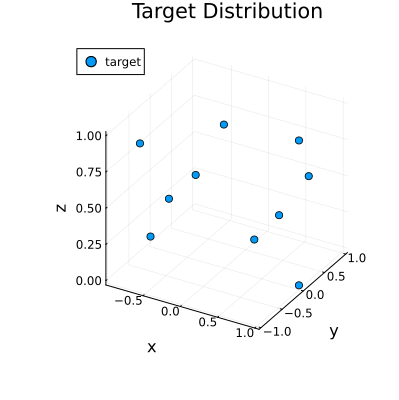

In [121]:
pos_tn_star = zeros(Float64, (3, n_particles))
pos_tn_star[1, :] = cos.(range(0, stop=4π, length=n_particles))
pos_tn_star[2, :] = sin.(range(0, stop=4π, length=n_particles))
pos_tn_star[3, :] = range(0, stop=1, length=n_particles)

# visualize the target distribution
scatter(
    pos_tn_star[1, :],
    pos_tn_star[2, :],
    pos_tn_star[3, :],
    label="target",
    xlabel="x",
    ylabel="y",
    zlabel="z",
    title="Target Distribution",
    legend=:topleft,
    size=(400, 400))

Now we can find the gradients of the loss with respect to the final positions of the particles.

We introduce the backward function, which passes the gradients through the simulation.

In [122]:
@views function grad(
    pos :: AbstractArray{Float64, 3},
    vel :: AbstractArray{Float64, 3},
    partial_pos :: AbstractArray{Float64, 3},
    partial_vel :: AbstractArray{Float64, 3},
    pos_star :: AbstractArray{Float64, 2},
    dt :: Float64,
    n_steps :: Int) :: Nothing

    loss_value = zeros(Float64, 1)
    partial_loss = ones(Float64, 1)
    partial_pos = ones(Float64, (n_steps+1, 3, n_particles))

    @views begin
        autodiff(
            Reverse,
            loss!, 
            Duplicated(pos[end, :, :], partial_pos[end, :, :]),
            Const(pos_tn_star),
            Duplicated(loss_value, partial_loss))
    end

    for i in n_steps:-1:2

        autodiff(
            Reverse,
            kdk!,
            Duplicated(pos[i, :, :], partial_pos[i, :, :]),
            Duplicated(vel[i, :, :], partial_vel[i, :, :]),
            Duplicated(pos[i+1, :, :], partial_pos[i+1, :, :]),
            Duplicated(vel[i+1, :, :], partial_vel[i+1, :, :]),
            Const(dt)
        )
        
    end

end
    

grad (generic function with 1 method)

In [125]:
# initialize the position and velocity
partial_vel = zeros(Float64, (n_steps+1, 3, n_particles))
partial_pos = ones(Float64, (n_steps+1, 3, n_particles))
pos = zeros(Float64, (n_steps+1, 3, n_particles))
vel = zeros(Float64, (n_steps+1, 3, n_particles))
pos[1, :, :] = randn(Float64, (3, n_particles))

n_particles = 10
n_steps = 20
dt = 0.01
n_epochs = 1000
for i in 1:n_epochs
    loss_value = zeros(Float64, 1)

    forward!(pos, vel, 0.01, n_steps)

    loss!(
        pos[end, :, :],
        pos_tn_star,
        loss_value)

    if i % 10 == 0
        display(loss_value)
        display(partial_pos[2, :, :])
    end
    
    # compute grad which is then stored in partial_pos
    grad(
        pos,
        vel,
        partial_pos,
        partial_vel,
        pos_tn_star,
        0.01,
        n_steps)

    # apply gradient descent
    pos[1, :, :] .-= 0.001 .* partial_pos[2, :, :]
    vel[1, :, :] .-= 0.001 .* partial_vel[2, :, :]
end


1-element Vector{Float64}:
 12.402498775133944

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 12.587231254363033

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 15.972066293985026

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 17.79190928978597

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 16.814445350368533

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 13.245073979272595

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 13.16000466612407

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 14.215753058690508

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 14.51993865504506

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 13.85128872878171

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 14.368087122204706

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 16.59808313399506

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 17.20822878931613

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 16.058162937973716

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 14.53493408175123

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 13.333824789022804

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 14.007068567918264

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 15.473216647112116

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 16.60296989164683

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 17.11217088509783

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 15.707975420401366

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 12.977138819422489

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 12.826418810584231

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 13.836597817298248

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 14.162134666478966

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 12.95401081822853

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 12.657465918766437

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 14.751829336856106

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 17.4276413265538

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 18.257205600694288

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 17.21856326611636

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 14.717708388821405

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 13.336412227257156

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 12.720698450975712

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 14.00986211664936

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 14.496455480193898

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 14.243183797768644

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 13.842388634828431

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 15.304517719091747

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 16.249382492474407

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 16.026261410324544

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 15.080796425547277

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 13.280619611928936

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 11.965198782251468

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 11.613532866206366

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 12.208272685947126

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 15.165609755917927

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 18.23537387017419

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 19.61098387851252

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 18.104815144992546

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 16.65596581097648

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 15.62869801228653

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 14.571501164366348

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 13.842660817535203

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 15.351718016628014

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 16.235661518338144

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 15.790786969570142

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 14.259131317311216

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 11.92477305664249

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 11.80220117793164

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 13.642264646893063

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 16.422155477301327

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 19.807835693404144

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 20.901596916171755

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 18.803359125804835

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 15.353220206518056

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 12.95499883949496

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 12.799641697250394

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 13.516759673369103

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 14.18541803545278

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 14.580342670111808

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 13.498218670826036

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 12.031031350375082

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 11.67425951918105

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 14.556127052445152

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 17.331720503410562

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 17.076624054451788

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 16.462535438863796

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 16.814798486733192

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 16.844572175775983

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 16.2067847704055

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 15.478671852159028

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 15.029535762931253

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 13.570700055547213

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 13.13639405573922

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 13.822985482277709

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 14.616226285232987

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 15.279289879743676

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 14.283510038062484

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 12.724509088192184

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 14.440502149241865

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 16.724509570396826

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 17.511201569599574

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 17.736374544096222

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 17.839198961609647

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 17.43856336584313

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 16.510025648449094

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 16.9923633238784

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 15.915837918531238

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

1-element Vector{Float64}:
 13.63776310827716

3×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [54]:
partial_vel[1, :, :]

3×5 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0